# Chapter 12: Image Representation by Feature Extraction

This is the companion file for Chapter 12.


## Programming exercise 12.1:

1.   Run the following code to perform polygon approximation by splitting.

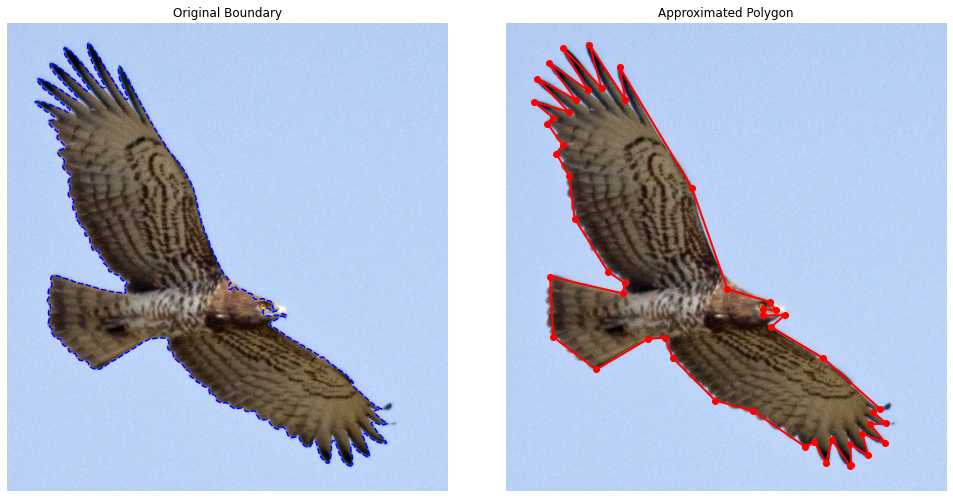

In [1]:
# Polygon approximation by splitting
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, filters, measure, morphology, io
import urllib.request


def perpendicular_distance(point, line_start, line_end):
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    line = line_end - line_start
    t = np.dot(point - line_start, line) / np.dot(line, line)
    t = np.clip(t, 0, 1)
    projection = line_start + t * line
    return np.linalg.norm(point - projection)

def split_polygon(points, start_idx, end_idx, threshold, result):
    start_point = points[start_idx]
    end_point = points[end_idx]
    max_distance = -1
    index_of_max = -1
    for i in range(start_idx + 1, end_idx):
        dist = perpendicular_distance(points[i], start_point, end_point)
        if dist > max_distance:
            max_distance = dist
            index_of_max = i
    if max_distance > threshold:
        split_polygon(points, start_idx, index_of_max, threshold, result)
        split_polygon(points, index_of_max, end_idx, threshold, result)
    else:
        result.append(end_idx)

def polygon_approximation_with_splitting(boundary_points, threshold):
    result = [0]
    split_polygon(boundary_points, 0, len(boundary_points) - 1, threshold, result)
    return boundary_points[result]

# Download the image from the specified URL
url = "https://raw.githubusercontent.com/itironal/466Companion/main/images/20.jpg"
urllib.request.urlretrieve(url, "images/20.jpg")

image_rgb = io.imread("images/20.jpg")  
image_rgb = image_rgb[500:1350, 600:1400]
# Convert to grayscale
gray = color.rgb2gray(image_rgb)

# Apply thresholding (Otsu)
thresh = filters.threshold_otsu(gray)
binary = gray < thresh  # Invert if needed depending on your object

# Clean mask
binary = morphology.remove_small_objects(binary, min_size=500)
binary = morphology.binary_closing(binary, morphology.disk(3))
binary = morphology.remove_small_holes(binary, area_threshold=1000)

# Find contours
contours = measure.find_contours(binary, 0.5)
contour = max(contours, key=len)  # largest one

# Downsample for speed
contour = contour[::5]

# Polygon approximation
threshold = 10.0
approx_polygon = polygon_approximation_with_splitting(contour, threshold)

# Plot original and approximated contours separately
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Original Boundary Visualization
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.plot(contour[:, 1], contour[:, 0], linestyle='--', color='blue', linewidth=1.5)
plt.title("Original Boundary")
plt.axis('off')

# Approximated Polygon Visualization
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)
plt.plot([p[1] for p in approx_polygon], [p[0] for p in approx_polygon], 'ro-', linewidth=2)
plt.title("Approximated Polygon")
plt.axis('off')

plt.tight_layout()
plt.show()


## Programming exercise 12.2:

1.   Run the following code to perform polygon approximation by merging.

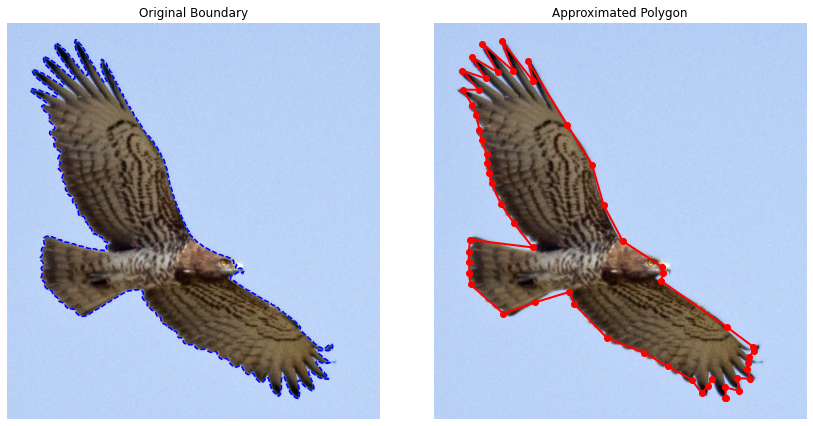

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology, io
from sklearn.linear_model import LinearRegression
import urllib.request

def least_squares_error(P):
    """ Compute Least Squares Error for the set of points P fitting a line. """
    # Prepare points (x, y)
    X = np.array([p[1] for p in P]).reshape(-1, 1)
    Y = np.array([p[0] for p in P])
    
    # Fit linear regression (a line) to the points
    model = LinearRegression()
    model.fit(X, Y)
    
    # The parameters of the line
    a = model.coef_[0]
    b = model.intercept_
    
    # Predict the y values using the line
    Y_pred = model.predict(X)
    
    # Calculate the Least Squares Error (sum of squared errors)
    L = np.sum((Y - Y_pred) ** 2)
    
    return a, b, L

def polygon_approximation_by_merging(boundary_points, threshold):
    P = [boundary_points[0]]  # Start with the first point
    vertices = []  # Store the vertices
    for i in range(1, len(boundary_points)):
        P.append(boundary_points[i])
        a, b, L = least_squares_error(P)
        
        # If the error is above threshold, add the last point as a vertex
        if L >= threshold:
            vertices.append(P[-2])  # Last pixel before the break
            P = [boundary_points[i]]  # Start new subset
    
    # Add the last point to the vertices
    vertices.append(P[-1])
    return vertices

# === MAIN PIPELINE ===

# Download the image from the specified URL
url = "https://raw.githubusercontent.com/itironal/466Companion/main/images/20.jpg"
urllib.request.urlretrieve(url, "images/20.jpg")

image_rgb = io.imread("images/20.jpg")  # Replace with your local image path if needed
image_rgb = image_rgb[500:1350, 600:1400]

# Convert to grayscale
gray = image_rgb.mean(axis=2)  # Simple grayscale conversion

# Apply thresholding (Otsu or simple thresholding)
thresh = gray.mean()  # Simple thresholding; you could use filters.threshold_otsu()
binary = gray < thresh  # Invert if needed depending on your object

# Clean mask (optional)
binary = morphology.remove_small_objects(binary, min_size=500)
binary = morphology.binary_closing(binary, morphology.disk(3))
binary = morphology.remove_small_holes(binary, area_threshold=1000)

# Find contours
contours = measure.find_contours(binary, 0.5)
contour = max(contours, key=len)  # largest contour

# Polygon approximation
threshold = 1000.0  # Adjust this threshold to control the "tightness" of the polygon
approx_polygon = polygon_approximation_by_merging(contour, threshold)

# Plot the original contour and the approximated polygon separately
plt.figure(figsize=(12, 6))

# Original Boundary Visualization
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.plot(contour[:, 1], contour[:, 0], linestyle='--', color='blue', linewidth=1.5)
plt.title("Original Boundary")
plt.axis('off')

# Approximated Polygon Visualization
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)
plt.plot([p[1] for p in approx_polygon], [p[0] for p in approx_polygon], 'ro-', linewidth=2)
plt.title("Approximated Polygon")
plt.axis('off')

plt.tight_layout()
plt.show()


## Programming exercise 12.3:

1.   Run the following code to perform medial axis transformation on sample T-shaped and L-shaped objects.

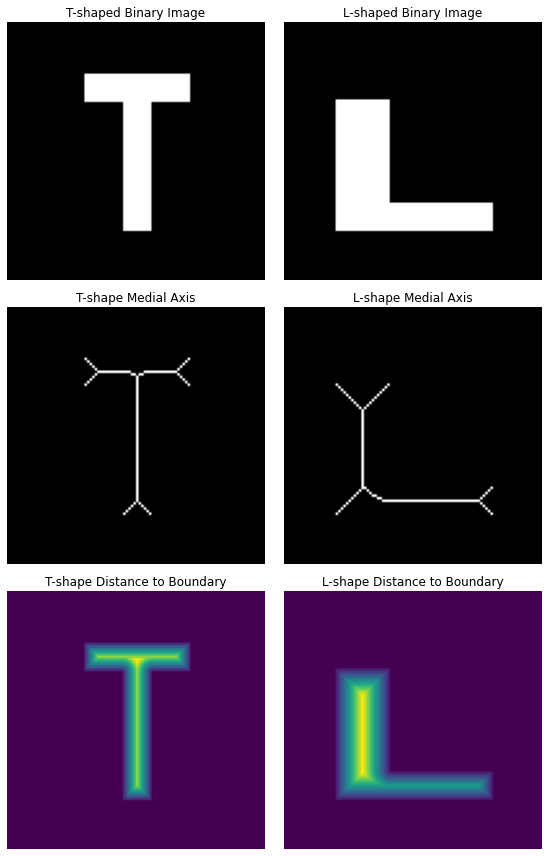

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis
from skimage.draw import rectangle

def create_T_shape_image(shape=(100, 100)):
    img = np.zeros(shape, dtype=bool)
    rr, cc = rectangle(start=(20, 45), end=(80, 55))
    img[rr, cc] = True
    rr, cc = rectangle(start=(20, 30), end=(30, 70))
    img[rr, cc] = True
    return img

def create_L_shape_image(shape=(100, 100)):
    img = np.zeros(shape, dtype=bool)
    rr1, cc1 = rectangle(start=(30, 20), end=(80, 40))
    img[rr1, cc1] = True
    rr2, cc2 = rectangle(start=(70, 40), end=(80, 80))
    img[rr2, cc2] = True
    return img

def compute_medial_axis(binary_image):
    skeleton, distance = medial_axis(binary_image, return_distance=True)
    return skeleton, distance

def plot_3x2(T_img, L_img, T_skel, T_dist, L_skel, L_dist):
    fig, axs = plt.subplots(3, 2, figsize=(8, 12))

    # Row 0: T-shape Original and L-shape Original
    axs[0, 0].imshow(T_img, cmap='gray')
    axs[0, 0].set_title("T-shaped Binary Image")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(L_img, cmap='gray')
    axs[0, 1].set_title("L-shaped Binary Image")
    axs[0, 1].axis('off')

    # Row 1: T-shape Medial Axis and L-shape Medial Axis
    axs[1, 0].imshow(T_skel, cmap='gray')
    axs[1, 0].set_title("T-shape Medial Axis")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(L_skel, cmap='gray')
    axs[1, 1].set_title("L-shape Medial Axis")
    axs[1, 1].axis('off')

    # Row 2: T-shape Distance and L-shape Distance
    axs[2, 0].imshow(T_dist, cmap='viridis')
    axs[2, 0].set_title("T-shape Distance to Boundary")
    axs[2, 0].axis('off')

    axs[2, 1].imshow(L_dist, cmap='viridis')
    axs[2, 1].set_title("L-shape Distance to Boundary")
    axs[2, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Run
T_img = create_T_shape_image()
L_img = create_L_shape_image()

T_skel, T_dist = compute_medial_axis(T_img)
L_skel, L_dist = compute_medial_axis(L_img)

plot_3x2(T_img, L_img, T_skel, T_dist, L_skel, L_dist)


## Programming exercise 12.4:

1.   Run the following code to visualize bounding box, diameter, equivalent diameter, major and minor axes of a shape.

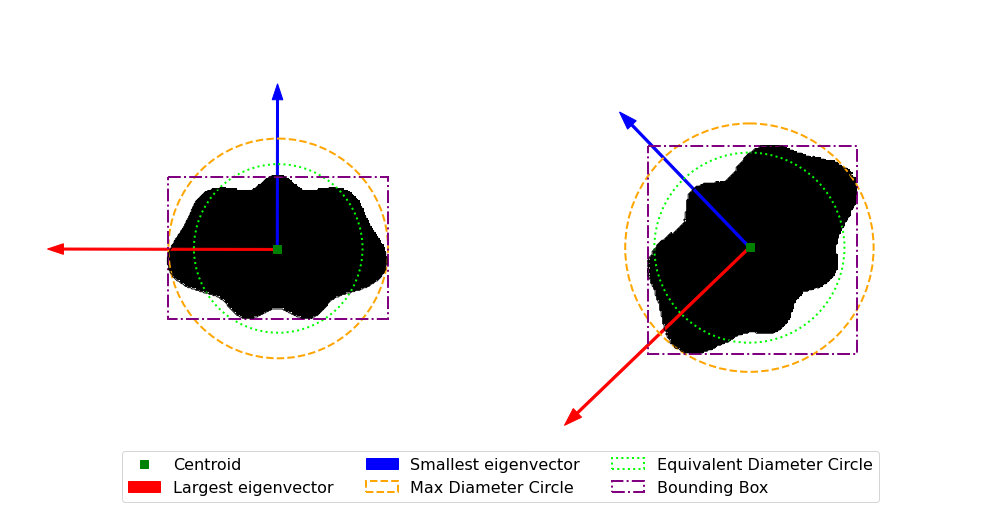

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
from skimage.measure import label, regionprops, find_contours
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import Circle, Rectangle
from scipy.ndimage import rotate

# --- Shape generation ---
def generate_wobbly_ellipse(shape=(300, 300)):
    img = np.zeros(shape, dtype=bool)
    cy, cx = shape[0] // 2, shape[1] // 2
    a, b = 80, 50
    theta = np.linspace(0, 2 * np.pi, 300)
    r = (a * b) / np.sqrt((b * np.cos(theta))**2 + (a * np.sin(theta))**2)
    r += 5 * np.sin(7 * theta)  # wobble
    x = cx + r * np.cos(theta)
    y = cy + r * np.sin(theta)
    rr, cc = polygon(y, x, shape)
    img[rr, cc] = 1
    return img

# --- Utility functions ---
def compute_max_diameter(contour):
    distances = squareform(pdist(contour))
    i, j = np.unravel_index(np.argmax(distances), distances.shape)
    return contour[i], contour[j], distances[i, j]

def draw_bounding_box(ax, bbox):
    minr, minc, maxr, maxc = bbox
    rect = Rectangle((minc, minr), maxc - minc, maxr - minr,
                     linewidth=2, edgecolor='purple', facecolor='none',
                     linestyle='-.', label='Bounding Box')
    ax.add_patch(rect)

def draw_circles(ax, centroid, max_diameter, equivalent_diameter):
    circle1 = Circle((centroid[1], centroid[0]), radius=max_diameter / 2,
                     fill=False, linestyle='--', edgecolor='orange', linewidth=2, label='Max Diameter Circle')
    circle2 = Circle((centroid[1], centroid[0]), radius=equivalent_diameter / 2,
                     fill=False, linestyle=':', edgecolor='lime', linewidth=2, label='Equivalent Diameter Circle')
    ax.add_patch(circle1)
    ax.add_patch(circle2)

def plot_ellipse(ax, img, angle=0):
    if angle != 0:
        img = rotate(img.astype(float), angle=angle, reshape=False) > 0.5
    labeled = label(img)
    props = regionprops(labeled)[0]
    contour = find_contours(img, 0.5)[0]

    # Eigenvectors
    contour_xy = contour[:, [1, 0]]
    centroid_xy = np.mean(contour_xy, axis=0)
    centered = contour_xy - centroid_xy
    cov = np.cov(centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
    scale = 3 * np.sqrt(eigvals)
    eigvecs_scaled = eigvecs * scale

    # Max diameter
    pt1, pt2, max_diam = compute_max_diameter(contour)

    # Plot
    ax.imshow(~img, cmap='gray', interpolation='none', vmin=0, vmax=1)
    ax.plot(contour_xy[:,0], contour_xy[:,1], 'k-', linewidth=1)
    ax.plot(centroid_xy[0], centroid_xy[1], 's', color='green', markersize=8, label='Centroid')

    ax.arrow(centroid_xy[0], centroid_xy[1],
             eigvecs_scaled[0,0], eigvecs_scaled[1,0],
             color='r', width=1.5, head_width=8, label='Largest eigenvector')
    ax.arrow(centroid_xy[0], centroid_xy[1],
             eigvecs_scaled[0,1], eigvecs_scaled[1,1],
             color='b', width=1.5, head_width=8, label='Smallest eigenvector')

    draw_circles(ax, centroid_xy, max_diam, props.equivalent_diameter)
    draw_bounding_box(ax, props.bbox)
    ax.axis('equal')
    #ax.set_title(f"Rotated {angle}°" if angle !=0 else "Original")
    ax.axis('off')

# --- Side-by-side plot ---
img = generate_wobbly_ellipse()
fig, axs = plt.subplots(1, 2, figsize=(14,7))
plot_ellipse(axs[0], img, angle=0)
plot_ellipse(axs[1], img, angle=45)

# Single legend, two lines, below figures
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(),
           loc='lower center', ncol=3, fontsize=16, frameon=True,
           bbox_to_anchor=(0.5, -0.02))

# --- After plotting ---
plt.tight_layout()

plt.show()

## Programming exercise 12.5:

1.   Run the following codes to see reconstruction from Fourier descriptors.

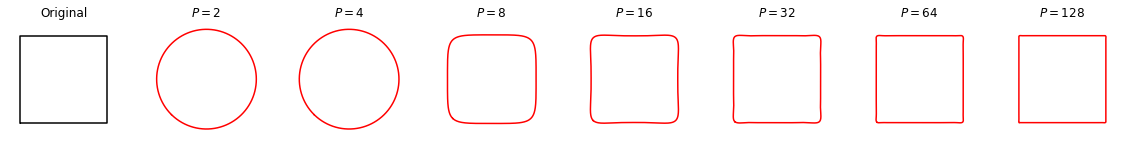

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_square_image(size=256):
    img = np.zeros((size, size), dtype=np.uint8)
    cv2.rectangle(img, (64, 64), (192, 192), 255, -1)
    return img

def get_contour_points(binary_img):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)
    contour = contour[:, 0, :]
    complex_contour = contour[:, 0] + 1j * contour[:, 1]
    return complex_contour

def resample_contour(contour, num_points=128):
    """Resample a closed contour to a fixed number of points using interpolation."""
    # Ensure it's a closed loop
    contour = np.append(contour, [contour[0]], axis=0)

    # Calculate cumulative arc length (distance along the contour)
    diff = np.diff(contour)
    dists = np.abs(diff)
    cumulative = np.concatenate(([0], np.cumsum(dists)))
    total_length = cumulative[-1]

    # Create evenly spaced target arc lengths
    desired = np.linspace(0, total_length, num_points, endpoint=False)

    # Interpolate real and imaginary parts separately
    real_interp = np.interp(desired, cumulative, contour.real)
    imag_interp = np.interp(desired, cumulative, contour.imag)

    return real_interp + 1j * imag_interp


def reconstruct_contour_sym(fd, P):
    N = len(fd)
    fd_shifted = np.fft.fftshift(fd)
    fd_filtered = np.zeros(N, dtype=complex)
    center = N // 2
    half_P = P // 2
    fd_filtered[center - half_P : center + half_P + P % 2] = fd_shifted[center - half_P : center + half_P + P % 2]
    fd_filtered = np.fft.ifftshift(fd_filtered)
    contour_rec = np.fft.ifft(fd_filtered)
    return np.real(contour_rec), np.imag(contour_rec)

def plot_reconstructions(original, reconstructions, Ps):
    fig, axs = plt.subplots(1, len(Ps)+1, figsize=(2 * (len(Ps)+1), 2))  # Smaller, square-friendly layout
    
    # Compute axis limits (shared for all plots)
    all_points = [original] + [x + 1j*y for x, y in reconstructions]
    all_real = np.concatenate([np.real(pts) for pts in all_points])
    all_imag = np.concatenate([np.imag(pts) for pts in all_points])
    xmin, xmax = all_real.min(), all_real.max()
    ymin, ymax = all_imag.min(), all_imag.max()
    margin = 10  # Add some padding
    xlim = (xmin - margin, xmax + margin)
    ylim = (ymin - margin, ymax + margin)

    # Original shape
    axs[0].plot(np.real(original), np.imag(original), 'k')
    axs[0].set_title("Original", fontsize=12)
    axs[0].set_xlim(xlim)
    axs[0].set_ylim(ylim)
    axs[0].set_aspect('equal')
    axs[0].axis('off')

    # Reconstructions
    for ax, (x, y), p in zip(axs[1:], reconstructions, Ps):
        ax.plot(x, y, 'r')
        ax.set_title(f"$P = {p}$", fontsize=12)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_aspect('equal')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Main
img = create_square_image()
contour = get_contour_points(img)
contour_centered = contour - np.mean(contour)
contour = resample_contour(contour, num_points=128)  
fd = np.fft.fft(contour_centered)

# Reconstruct using increasing number of descriptors
Ps = [2, 4, 8, 16, 32, 64, 128]
reconstructions = [reconstruct_contour_sym(fd, P) for P in Ps]

plot_reconstructions(contour_centered, reconstructions, Ps)


## Programming exercise 12.6:

1.   Run the following code to see Gabor filters.

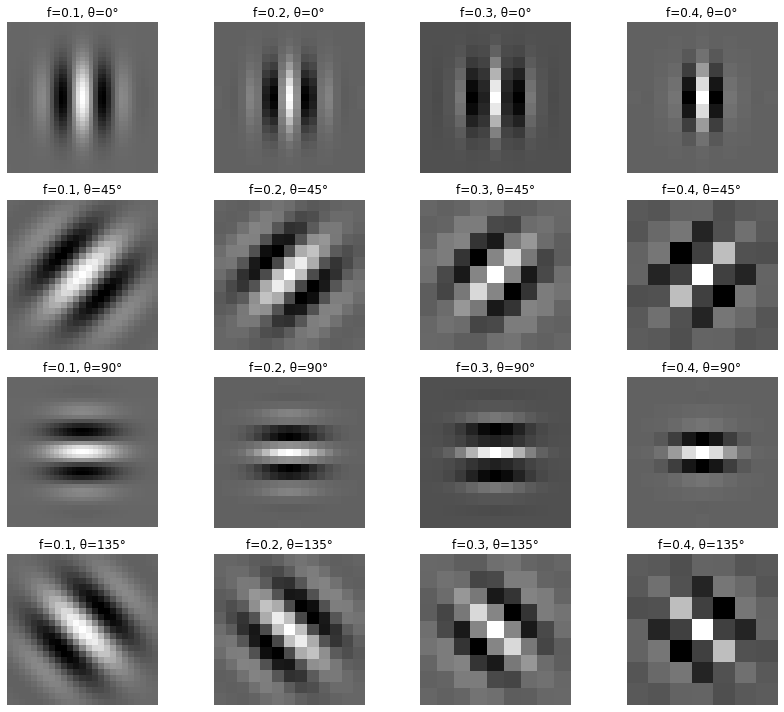

In [15]:
#Gabor Filters
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gabor_kernel

# Define Gabor kernel bank
frequencies = [0.1, 0.2, 0.3, 0.4]  # Spatial frequencies
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Orientations

# Create kernels
kernels = []
for theta in thetas:
    for freq in frequencies:
        kernel = gabor_kernel(frequency=freq, theta=theta)
        kernels.append((kernel, freq, theta))

# Plot real parts of the kernels
fig, axes = plt.subplots(len(thetas), len(frequencies), figsize=(12, 10))

for ax, (kernel, freq, theta) in zip(axes.ravel(), kernels):
    ax.imshow(np.real(kernel), cmap='gray')
    ax.set_title(f'f={freq:.1f}, θ={theta * 180 / np.pi:.0f}°')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Programming exercise 12.7:

1.   Run the following code to perform SIFT keypoint extraction and matching.

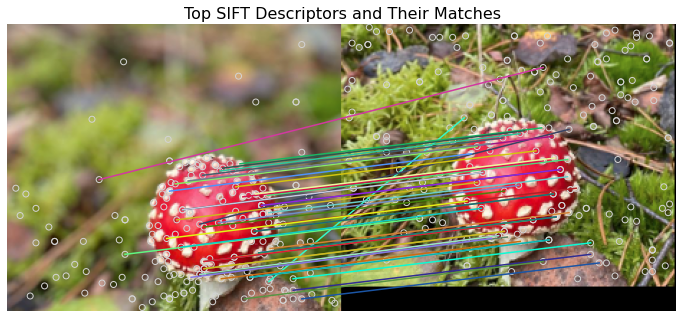

In [3]:
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from skimage.feature import match_descriptors, plot_matches, SIFT
import matplotlib.pyplot as plt
import numpy as np
import urllib.request


def read_rgb(path):
    img = io.imread(path)
    if img.shape[-1] == 4:
        img = rgba2rgb(img)
    return img

# Download the image from the specified URL
url = "https://raw.githubusercontent.com/itironal/466Companion/main/images/mushroom3.png"
urllib.request.urlretrieve(url, "images/mushroom3.png")

# Download the image from the specified URL
url = "https://raw.githubusercontent.com/itironal/466Companion/main/images/mushroom4.png"
urllib.request.urlretrieve(url, "images/mushroom4.png")

# Read images
image1 = read_rgb('images/mushroom3.png')
image2 = read_rgb('images/mushroom4.png')

# Convert to grayscale
image1_gray = rgb2gray(image1)
image2_gray = rgb2gray(image2)

# Extract SIFT descriptors
sift = SIFT()
sift.detect_and_extract(image1_gray)
keypoints1, descriptors1, scales1 = sift.keypoints, sift.descriptors, sift.scales

sift.detect_and_extract(image2_gray)
keypoints2, descriptors2, scales2 = sift.keypoints, sift.descriptors, sift.scales

# Select top k=100 descriptors by scale
def select_top_k(keypoints, descriptors, scales, k=100):
    idx = np.argsort(scales)[-k:]  # take largest k scales
    return keypoints[idx], descriptors[idx]

keypoints1, descriptors1 = select_top_k(keypoints1, descriptors1, scales1, k=200)
keypoints2, descriptors2 = select_top_k(keypoints2, descriptors2, scales2, k=200)

# Match descriptors
matches = match_descriptors(descriptors1, descriptors2, max_ratio=0.8, cross_check=True)


# Plot matches
fig, ax = plt.subplots(figsize=(12, 8))
plot_matches(ax, image1, image2, keypoints1, keypoints2, matches,
             keypoints_color='lightgray')
ax.set_title('Top SIFT Descriptors and Their Matches', fontsize=16)
ax.axis('off')
plt.savefig('sift_matches.pdf', bbox_inches='tight')
plt.show()


## Programming exercise 12.8:

1.   Run the following code to extract local binary patterns (LBP).

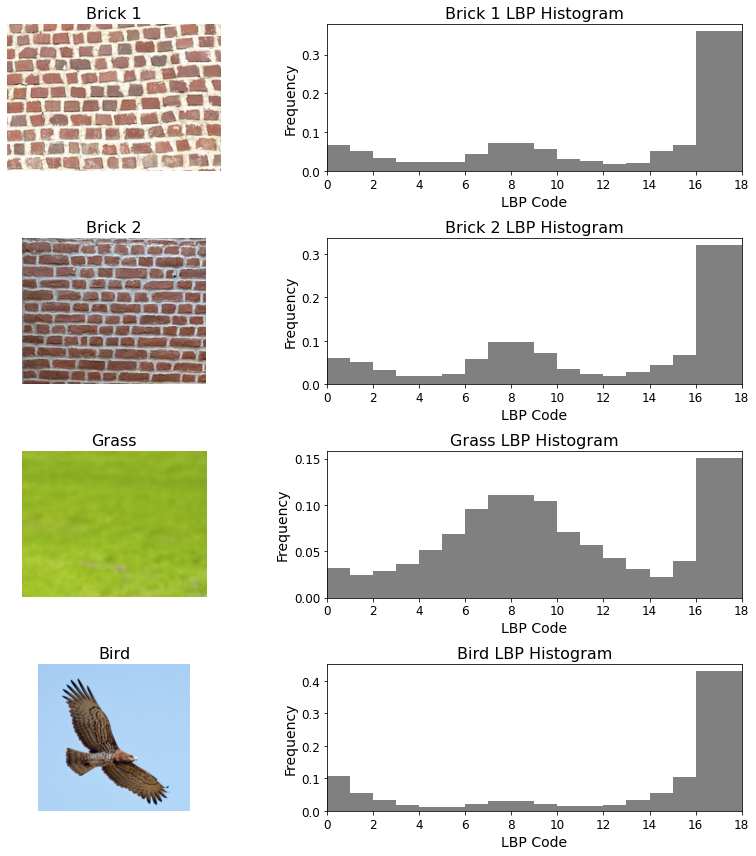

In [4]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import urllib.request


# Parameters
radius = 2
n_points = 8 * radius
method = 'uniform'

# Download the images from the specified URL
url = "https://raw.githubusercontent.com/itironal/466Companion/main/images/brick1.png"
urllib.request.urlretrieve(url, "images/brick1.png")
url = "https://raw.githubusercontent.com/itironal/466Companion/main/images/brick2.png"
urllib.request.urlretrieve(url, "images/brick2.png")
url = "https://raw.githubusercontent.com/itironal/466Companion/main/images/grass.png"
urllib.request.urlretrieve(url, "images/grass.png")
url = "https://raw.githubusercontent.com/itironal/466Companion/main/images/bird.png"
urllib.request.urlretrieve(url, "images/bird.png")

# Images and titles
images = ['images/brick1.png', 'images/brick2.png', 'images/grass.png', 'images/bird.png']
titles = ['Brick 1', 'Brick 2', 'Grass', 'Bird']

# Preprocess helper
def preprocess_image(path):
    img = io.imread(path)
    if img.ndim == 3 and img.shape[-1] == 4:
        img = rgba2rgb(img)
    return img, rgb2gray(img)

# Histogram plot helper
def plot_lbp_histogram(ax, lbp):
    counts, bins = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
    ax.bar(bins[:-1], counts, width=2, color='gray')
    ax.set_xlim(0, n_points + 2)
    ax.set_xlabel('LBP Code', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_xticks(np.arange(0, n_points + 3, 2))
    ax.tick_params(axis='both', labelsize=12)

# Create a grid with 2 rows per image
fig, axes = plt.subplots(len(images), 2, figsize=(12, 3 * len(images)))

for i, path in enumerate(images):
    color_img, gray = preprocess_image(path)
    lbp = local_binary_pattern(gray, P=n_points, R=radius, method=method)

    # Show color image
    axes[i, 0].imshow(color_img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(titles[i], fontsize=16)

    # Show histogram
    plot_lbp_histogram(axes[i, 1], lbp)
    axes[i, 1].set_title(f'{titles[i]} LBP Histogram', fontsize=16)

plt.tight_layout()
plt.show()
